# Daily Climate - Time Series Forecasting of Daily Temperature
In this project, I am building a model to predict the average daily temperature  
I start with a simple baseline model and gradually improve it by adding features such as trend, seasonality, and lag  
All models are compared on a validation set, and the final evaluation is performed on a separate test set  

## Data loading and Preparation
The dataset is loaded, the date column is converted to datetime format, and the data is sorted by time  
The date column is used as an index 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

train_df = pd.read_csv("C:\\Users\\lb_20\\Downloads\\DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("C:\\Users\\lb_20\\Downloads\\DailyDelhiClimateTest.csv")

for df in (train_df, test_df):
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values("date", inplace=True)
    df.set_index("date", inplace=True)

train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Exploratory Data Analysis
The average daily temperature graph shows the overall trend over time  
The graph has a clear annual seasonality 

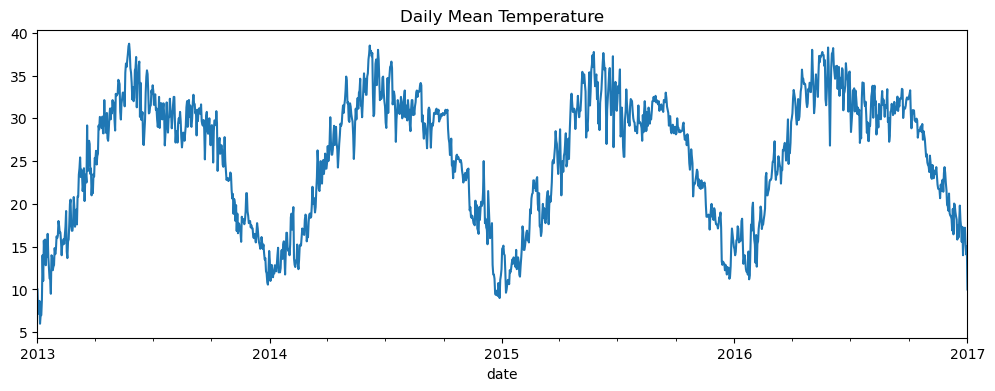

In [5]:
train_df["meantemp"].plot(figsize = (12, 4), title = "Daily Mean Temperature")
plt.show()

## Train / Validation split
The data is split by time  
The model is trained on data before 2016 and validated on data from 2016  

In [7]:
train_df.index.min(), train_df.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-01-01 00:00:00'))

In [8]:
split_date = pd.to_datetime("2016-01-01")
train = train_df.loc[train_df.index < split_date].copy()
val = train_df.loc[train_df.index >= split_date].copy()

print(len(train), len(val), sep = "\n")

1095
367


## Baseline model
The basic model uses an approach in which the last value from the training data set serves as a prediction for all validation points  
This allows to determine the baseline level of model performance

In [10]:
y_val = val["meantemp"]
last_value = train["meantemp"].iloc[-1]
y_val_pred = np.full(len(y_val), last_value)

mae_base = mean_absolute_error(y_val, y_val_pred)
mae_base

12.269076819858387

## Feature engineering
A number of features are defined for the models:

- a time index for modeling trends
- Fourier features, which capture annual seasonality 
- lag features for the target variable, showing short-term dependencies

The same feature creation method is used for data intended for training, validation, and testing.

In [12]:
train_fe = train.copy()
val_fe = val.copy()
test_fe = test_df.copy()

origin = train_df.index.min()

train_fe["time_idx"] = (train_fe.index - origin).days
val_fe["time_idx"] = (val_fe.index - origin).days
test_fe["time_idx"] = (test_fe.index - origin).days

period = 365
K = 1

t_train = train_fe["time_idx"].to_numpy(dtype = float)
t_val = val_fe["time_idx"].to_numpy(dtype = float)
t_test = test_fe["time_idx"].to_numpy(dtype = float)

for k in range(1, K + 1):
    train_fe[f"sin_{period}_k{k}"] = np.sin(2 * np.pi * k * t_train / period)
    train_fe[f"cos_{period}_k{k}"] = np.cos(2 * np.pi * k * t_train / period)

    val_fe[f"sin_{period}_k{k}"] = np.sin(2 * np.pi * k * t_val / period)
    val_fe[f"cos_{period}_k{k}"] = np.cos(2 * np.pi * k * t_val / period)

    test_fe[f"sin_{period}_k{k}"] = np.sin(2 * np.pi * k * t_test / period)
    test_fe[f"cos_{period}_k{k}"] = np.cos(2 * np.pi * k * t_test / period)

lags = [1, 7, 14]
for lag in lags:
    train_fe[f"lag_{lag}"] = train_fe["meantemp"].shift(lag)
    val_fe[f"lag_{lag}"] = val_fe["meantemp"].shift(lag)
    test_fe[f"lag_{lag}"] = test_fe["meantemp"].shift(lag)

train_fe = train_fe.dropna()
val_fe = val_fe.dropna()
test_fe = test_fe.dropna()

## Model 1: Trend only
This model uses only the time index as a feature  
It shows how much of the data can be explained by a simple linear trend

In [14]:
X_train = train_fe[["time_idx"]]
y_train = train_fe[["meantemp"]]

X_val = val_fe[["time_idx"]]
y_val = val_fe[["meantemp"]]

m1 = LinearRegression()
m1.fit(X_train, y_train)
pred_val_m1 = m1.predict(X_val)

mae_m1 = mean_absolute_error(y_val, pred_val_m1)
mae_m1

6.176450000384599

## Model 2: Trend + Seasonality
Fourier features are added to model yearly seasonality  
This allows the model to capture regular seasonal temperature patterns

In [16]:
fourier_cols = [f"sin_{period}_k1", f"cos_{period}_k1"]

X_train = train_fe[["time_idx"] + fourier_cols]
y_train = train_fe["meantemp"]

X_val = val_fe[["time_idx"] + fourier_cols]
y_val = val_fe["meantemp"]

m2 = LinearRegression()
m2.fit(X_train, y_train)
pred_val_m2 = m2.predict(X_val)

mae_m2 = mean_absolute_error(y_val, pred_val_m2)
mae_m2

3.2664430382011007

## Model 3: Trend + Seasonality + Lags
Lag features of the target variable are added to capture short-term temporal dependencies  
This model makes predictions way more accurate

In [18]:
lag_cols = [f"lag_{l}" for l in lags]

X_train = train_fe[["time_idx"] + fourier_cols + lag_cols]
y_train = train_fe["meantemp"]

X_val = val_fe[["time_idx"] + fourier_cols + lag_cols]
y_val = val_fe["meantemp"]

m3 = LinearRegression()
m3.fit(X_train, y_train)
pred_val_m3 = m3.predict(X_val)

mae_m3 = mean_absolute_error(y_val, pred_val_m3)
mae_m3

1.2401727168945997

## Model 4: Adding Exogenous Variables
Additional weather variables such as humidity, wind speed, and pressure are included  
A pipeline is used to handle missing values and feature scaling

In [20]:
exog_cols = ["humidity", "wind_speed", "meanpressure"]

X_train = train_fe[["time_idx"] + fourier_cols + lag_cols + exog_cols]
y_train = train_fe["meantemp"]

X_val = val_fe[["time_idx"] + fourier_cols + lag_cols + exog_cols]
y_val = val_fe["meantemp"]

m4 = Pipeline(steps = [("imputer", SimpleImputer(strategy = "median")),
                       ("scaler", StandardScaler(with_mean = False)),
                       ("model", LinearRegression())])

m4.fit(X_train, y_train)
pred_val_m4 = m4.predict(X_val)

mae_m4 = mean_absolute_error(y_val, pred_val_m4)
mae_m4

3.8014990935265964

## Model comparison
All models are compared using the MAE metric on the same validation set

In [22]:
results = pd.DataFrame({"Model": ["M0 Base (last value)",
                                  "M1 Trend",
                                  "M2 Trend + Fourier",
                                  "M3 Trend + Fourier + Lags",
                                  "M4 Trend + Fourier + Lags + Exogenous"],
                       "MAE": [mae_base, mae_m1, mae_m2, mae_m3, mae_m4]}).sort_values("MAE")
results

,Model,MAE
3,M3 Trend + Fourier + Lags,1.240173
2,M2 Trend + Fourier,3.266443
4,M4 Trend + Fourier + Lags + Exogenous,3.801499
1,M1 Trend,6.176450
0,M0 Base (last value),12.269077


## Validation results
The plot compares actual and predicted temperature values for the best model on the validation set  
The model closely follows the overall temperature pattern

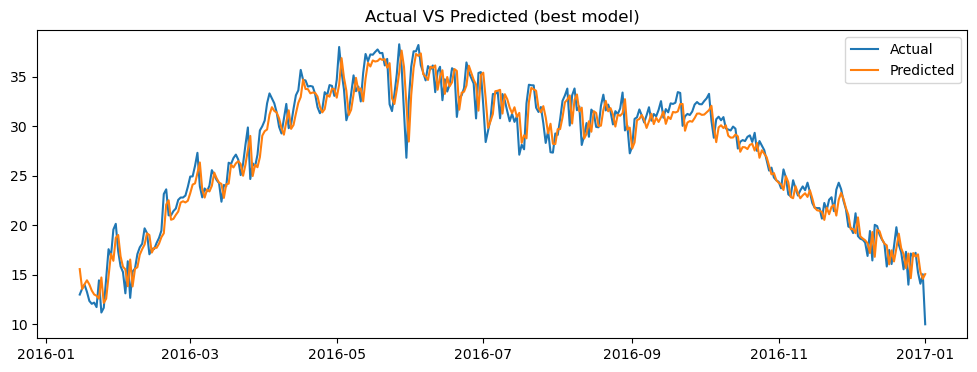

In [24]:
plt.figure(figsize = (12, 4))
plt.plot(y_val.index, y_val.values, label = "Actual")
plt.plot(y_val.index, pred_val_m3, label = "Predicted")
plt.title("Actual VS Predicted (best model)")
plt.legend()
plt.show()

## Final model Evaluation on Test Data
The final model is trained on all available training data and evaluated once on the test set  
This allows for an objective evaluation of effectiveness based on previously unknown data

In [26]:
full_train_fe = train_fe.copy()
full_test_fe = test_fe.copy()

full_train_fe["time_idx"] = (full_train_fe.index - origin).days
full_test_fe["time_idx"] = (full_test_fe.index - origin).days

t_full_train = full_train_fe["time_idx"].to_numpy(dtype = float)
t_full_test = full_test_fe["time_idx"].to_numpy(dtype = float)

for k in range(1, K + 1):
    full_train_fe[f"sin_{period}_k{k}"] = np.sin(2*np.pi*k*t_full_train/period)
    full_train_fe[f"cos_{period}_k{k}"] = np.cos(2*np.pi*k*t_full_train/period)

    full_test_fe[f"sin_{period}_k{k}"] = np.sin(2*np.pi*k*t_full_test/period)
    full_test_fe[f"cos_{period}_k{k}"] = np.cos(2*np.pi*k*t_full_test/period)

for lag in lags:
    full_train_fe[f"lag_{lag}"] = full_train_fe["meantemp"].shift(lag)
    full_test_fe[f"lag_{lag}"]  = full_test_fe["meantemp"].shift(lag)

full_train_fe = full_train_fe.dropna()
full_test_fe  = full_test_fe.dropna()

X_train_full = full_train_fe[["time_idx"] + fourier_cols + lag_cols]
y_train_full = full_train_fe["meantemp"]

X_test = full_test_fe[["time_idx"] + fourier_cols + lag_cols]
y_test = full_test_fe["meantemp"]

final_model = LinearRegression()
final_model.fit(X_train_full, y_train_full)
pred_test = final_model.predict(X_test)

mae_test = mean_absolute_error(y_test, pred_test)
mae_test
    

1.2504112021279388

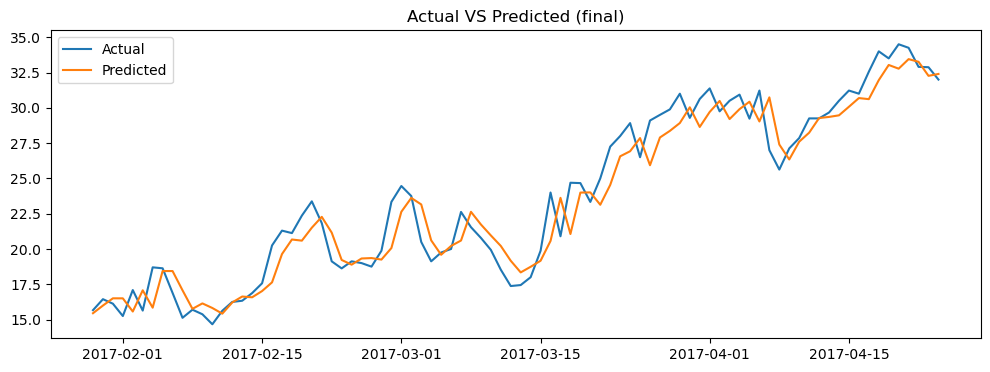

In [27]:
plt.figure(figsize = (12, 4))
plt.plot(y_test.index, y_test.values, label = "Actual")
plt.plot(y_test.index, pred_test, label = "Predicted")
plt.title("Actual VS Predicted (final)")
plt.legend()
plt.show()

## Residual Analysis
Residuals are analyzed over time and using autocorrelation plots  
They fluctuate around zero and show no strong remaining structure, indicating a well-fitted model

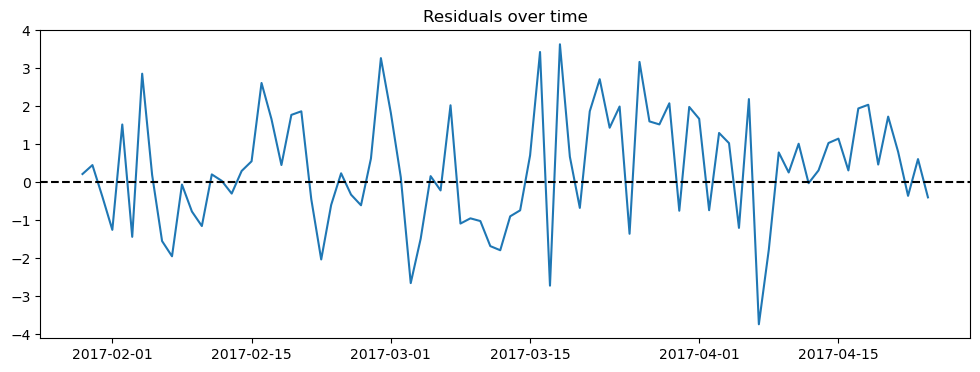

In [29]:
residuals = y_test - pred_test

plt.figure(figsize = (12, 4))
plt.plot(y_test.index, residuals)
plt.axhline(0, color = "black", linestyle = "--")
plt.title("Residuals over time")
plt.show()

## Residual Autocorrelation
The autocorrelation function (ACF) is used to check whether residuals still contain temporal dependence  
Most autocorrelation values lie within the confidence interval, indicating that the model has captured the main time-related structure

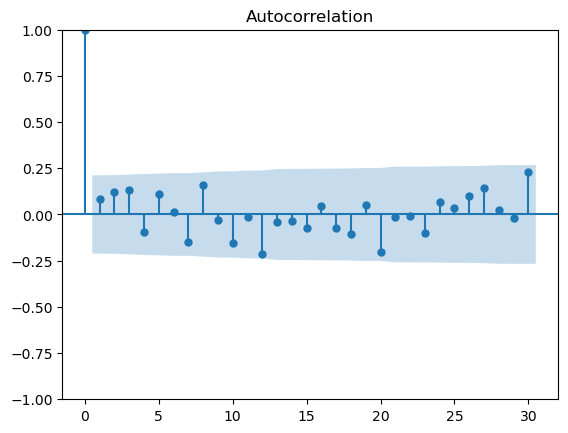

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags = 30)
plt.show()

## Interpretation of model coefficients
Since a linear regression model is used, the feature coefficients can be interpreted directly  
Sorting the coefficients by absolute value helps to identify the main factors influencing the forecast

In [33]:
pd.Series(final_model.coef_, index = X_train_full.columns).sort_values(key = np.abs, ascending = False)

cos_365_k1   -1.038585
lag_1         0.782823
sin_365_k1    0.212921
lag_7         0.068009
lag_14        0.042514
time_idx     -0.000005
dtype: float64